In [43]:
from psycopg2 import connect
import configparser
%matplotlib inline
import numpy as np
import pandas as pd
import pandas.io.sql as pandasql
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set(color_codes=True)
from IPython.display import HTML

def print_table(sql, con):
    return HTML(pandasql.read_sql(sql, con).to_html(index=False))
CONFIG = configparser.ConfigParser()
CONFIG.read('db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

In [2]:
# q1: What routes are we getting?
sql1 ='''
SELECT route, count(route)
FROM ttc.cis_2017
GROUP BY route
ORDER BY route
 '''

print_table(sql1, con)

route,count
301,2682467
304,292092
306,1453126
310,38114
501,57833907
502,5630170
503,2421395
504,35297179
505,22156141
506,32968842


In [3]:
# q2: How does data quantity vary by month?
sql2 ='''
SELECT date_part('month', message_datetime) AS month, count(route)
FROM ttc.cis_2017
GROUP BY month
 '''

print_table(sql2, con)

month,count
1.0,19348204
2.0,17537166
3.0,19757409
4.0,18671319
5.0,19431555
6.0,19364757
7.0,19875493
8.0,19758310
9.0,18729240
10.0,19373990


In [4]:
# q3: What are duplicate records with same vehicle and message_datetime?

sql3 = '''
select * INTO dzou2.cis_dup
from (
  SELECT *,
  COUNT(1) OVER(PARTITION BY vehicle, message_datetime) AS cnt
  FROM ttc.cis_2017
) dups
where 
dups.cnt > 1    
'''

## The selected data includes 19636 rows of data, so the table is not printed and the data are stored in dzou2.cis_dup. 
## There are some anlysis of the duplicates in the markdown cell. 


Total number of of the duplicate vehicle and timestamp: __19636__

```sql
sql = SELECT count(*) FROM dzou2.cis_dup
```

Numbers of 

exact duplicate: __16736__

routes and runs both different in different positions:__186__

routes and runs both different in matched positions:__22__

same routes different runs in different positions:__1784__

same routes different runs in matched positions:__618__

same runs different routes in different positions:__178__

same runs different routes in matched positions:__112__

``` sql
sql = 
--Put all possible duplicate columns into array
WITH grouped AS (SELECT vehicle, message_datetime, 
ARRAY_AGG(route) as routes, ARRAY_AGG(run) as runs, array_agg('[' || latitude || ',' || longitude || ']') as pos
FROM dzou2.cis_dup
GROUP BY vehicle, message_datetime)
--Classify type of  duplication
, classified AS(SELECT vehicle, message_datetime,
CASE WHEN pos[1] = pos[2] AND routes[1] = routes[2] AND runs[1] = runs[2]
THEN 'exact duplicate'
WHEN pos[1] = pos[2] AND routes[1] <> routes[2] AND runs[1] = runs[2] 
THEN 'same runs different routes in matched positions'
WHEN pos[1] <> pos[2] AND routes[1] <> routes[2] AND runs[1] = runs[2] 
THEN 'same runs different routes in different positions'
WHEN pos[1] = pos[2] AND routes[1] = routes[2] AND runs[1] <> runs[2] 
THEN 'same routes different runs in matched positions'
WHEN pos[1] <> pos[2] AND routes[1] = routes[2] AND runs[1] <> runs[2] 
THEN 'same routes different runs in different positions'
WHEN pos[1] = pos[2] AND routes[1] <> routes[2] AND runs[1] <> runs[2] 
THEN 'routes and runs both different in matched positions'
WHEN pos[1] <> pos[2] AND routes[1] <> routes[2] AND runs[1] <> runs[2] 
THEN 'routes and runs both different in different positions'
ELSE 'others'
END AS type_of_dupe
FROM grouped)
--Breakdown of duplication types
SELECT type_of_dupe, COUNT(1)*2 AS count
FROM classified
GROUP BY type_of_dupe
ORDER BY type_of_dupe
```


In [5]:
# q4 part a: How do number of vehicles per route vary by month?
sql4a = '''
SELECT count (DISTINCT (vehicle, message_datetime)), route, date_part('month', message_datetime) AS month
FROM ttc.cis_2017
GROUP BY route, month
'''

print_table(sql4a, con)

count,route,month
225395,301,1.0
223961,301,2.0
232997,301,3.0
217507,301,4.0
245032,301,5.0
230405,301,6.0
210832,301,7.0
222923,301,8.0
194206,301,9.0
221592,301,10.0


In [7]:
# q4 part b: How do points per route vary by month?
sql4b = '''
SELECT count(DISTINCT (position, message_datetime)), route, date_part('month', message_datetime) AS month
FROM ttc.cis_2017
GROUP BY route, month
'''

print_table(sql4b, con)


count,route,month
225389,301,1.0
223933,301,2.0
232913,301,3.0
217494,301,4.0
244996,301,5.0
230391,301,6.0
210816,301,7.0
222900,301,8.0
194163,301,9.0
221519,301,10.0


In [8]:
# the frequency of a run number change for a vehicle in the example of route 504 on 2017-01-30
sqlf = '''
SELECT vehicle, route, run, MIN(message_datetime) run_start, MAX(message_datetime) run_end, MAX(message_datetime) - MIN(message_datetime) run_length
FROM ttc.cis_2017
WHERE date(message_datetime) = '2017-01-30' AND route = '504'
GROUP BY vehicle, route, run
ORDER BY vehicle, run_start
'''

print_table(sqlf, con)

vehicle,route,run,run_start,run_end,run_length
1350,504,51,2017-01-30 21:30:20,2017-01-30 23:59:40,02:29:20
4004,504,28,2017-01-30 06:37:00,2017-01-30 23:59:40,17:22:40
4010,504,2,2017-01-30 06:58:40,2017-01-30 16:01:00,09:02:20
4010,504,30,2017-01-30 16:01:20,2017-01-30 23:59:40,07:58:20
4014,504,19,2017-01-30 05:00:40,2017-01-30 22:41:20,17:40:40
4015,504,40,2017-01-30 05:31:00,2017-01-30 09:04:20,03:33:20
4015,504,14,2017-01-30 09:04:40,2017-01-30 20:22:00,11:17:20
4025,504,43,2017-01-30 07:21:00,2017-01-30 10:37:40,03:16:40
4025,504,23,2017-01-30 10:38:00,2017-01-30 22:19:20,11:41:20
4028,504,8,2017-01-30 00:00:00,2017-01-30 01:54:20,01:54:20


In [16]:
# pivot table of the issue types by route
sql_types = '''
SELECT type_of_dupe, route, count(*) AS observations
FROM dzou2.cis_dup_groups
WHERE type_of_dupe <> 'exact duplicate'
GROUP BY type_of_dupe, route
ORDER BY type_of_dupe
'''
df = pandasql.read_sql(sql_types, con)
table = pd.pivot_table(df, values='observations', index=['route'], columns=['type_of_dupe'])
table

type_of_dupe,routes and runs both different in different positions,routes and runs both different in matched positions,same routes different runs in different positions,same routes different runs in matched positions,same runs different routes in different positions,same runs different routes in matched positions
route,,,,,,
301,30.0,NaN,2.0,NaN,47.0,33.0
304,NaN,NaN,284.0,NaN,7.0,1.0
306,46.0,NaN,20.0,NaN,14.0,11.0
310,NaN,NaN,NaN,NaN,2.0,NaN
501,5.0,3.0,158.0,48.0,51.0,35.0
502,1.0,1.0,NaN,NaN,7.0,7.0
503,NaN,2.0,8.0,4.0,7.0,7.0
504,37.0,3.0,288.0,100.0,11.0,2.0
505,6.0,2.0,216.0,64.0,3.0,1.0


In [40]:
# range of # observations/day for weekday and weekend
sql_week = '''
SELECT count(*) AS observation, date(message_datetime) AS date, 
(CASE WHEN EXTRACT(isodow FROM date(message_datetime)) > 0 AND EXTRACT(isodow FROM date(message_datetime)) < 6
      THEN 'weekday'
      WHEN EXTRACT(isodow FROM date(message_datetime)) = 6 OR EXTRACT(isodow FROM date(message_datetime)) = 7
      THEN 'weekend'
END) AS day
FROM ttc.cis_2017
GROUP BY date
'''
df = pandasql.read_sql(sql_week, con)

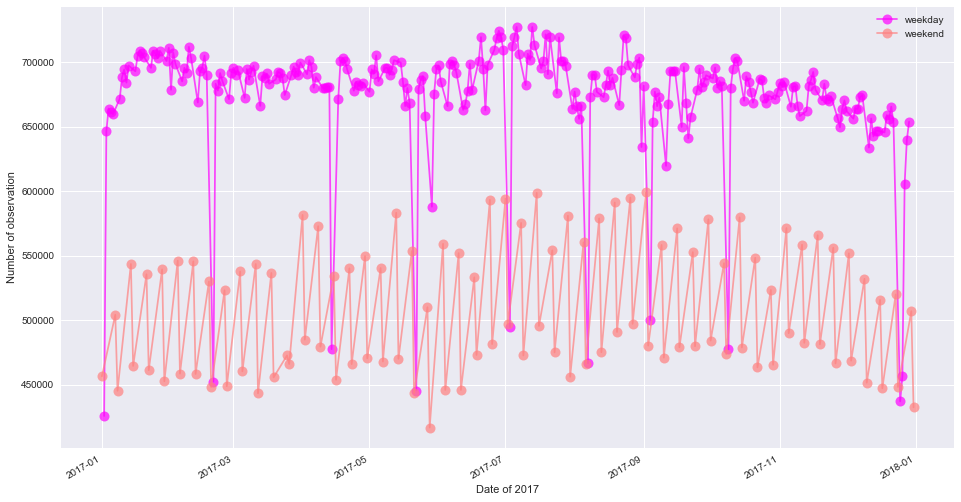

In [46]:
weekend_data = df[(df['day'] == 'weekend')]
weekday_data = df[(df['day'] == 'weekday')]

fig, ax = plt.subplots(1,1,figsize=(16,9))
NUM_COLORS = 2
cm = plt.get_cmap('spring')
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

ax.plot(weekday_data.date, weekday_data.observation, marker='o', markersize=10, alpha=0.7,
            linestyle='-', label="weekday", color=colors[0])

ax.plot(weekend_data.date, weekend_data.observation, marker='o', markersize=10, alpha=0.7,
            linestyle='-', label="weekend", color=colors[1])

ax.legend()
plt.gcf().autofmt_xdate() 
ax.set_xlabel('Date of 2017')
ax.set_ylabel('Number of observation')
